# Variational Autoencoder
Implementation based on the following papers:
- [Auto Encoding Varational Bayes](https://arxiv.org/abs/1312.6114)
- [Variational Autoencoder for Deep Learning of Images, Labels and Captions](https://papers.nips.cc/paper/6528-variational-autoencoder-for-deep-learning-of-images-labels-and-captions.pdf)



## 1. Import dependencies
Import the modules neccessary to run the project. If you get a 
``` 
Error: Module not found
```
run the following code in a separate cell 
``` 
!pip install -r requirements.txt 

```

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

Check if a CUDA GPU is available, and if yes use it. Else use the CPU for computations.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using %s for computation" % device)

Using cuda for computation


In [3]:
project_dir = 'results/'
dataset_dir = project_dir + 'datasets/'
images_dir = project_dir + 'images/'
model_dir = project_dir + 'model/'

## 2. Tune Hyperparameters
Set up the hyperparameters for the model. If you get any errors about running out of memeory, try reducing the batch size. 

The latent size is the size of the encoding vector that the Encoder finally produces. Increasing this value can improve performance, but there are diminishing returns once you cross a certain limit.

In [4]:
batch_size = 32           # number of inputs in each batch
epochs = 10               # times to run the model on complete data
image_size = 64
hidden_size = 1024        # hidden dimension
latent_size = 32          # latent vector dimension
lr = 1e-3                 # learning rate
train_loss = []

# If you want to use the Vanilla VAE, uncomment the following block
# image_size = 28
# input_size = image_size ** 2  # size of each input
# hidden_size = 300  # hidden dimension
# latent_size = 45  # latent vector dimension

## 3. Load Data and DataLoader


In [28]:
from torchvision import transforms as tmf
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image as IMG

class CelebDataset(Dataset):
    def __init__(self, **kw):
        self.images_dir = kw.get('images_dir')
        self.images = os.listdir(self.images_dir)
        self.images = self.images[:kw.get('lim', len(self.images))]
        self.image_size = kw.get('image_size', 64)

    def __getitem__(self, index):
        file = self.images[index]
        img = self.transforms(IMG.open(self.images_dir + os.sep + file))
        return {'input': img}
    
    def __len__(self):
        return len(self.images)

    @property
    def transforms(self):
        return tmf.Compose(
            [tmf.Resize(self.image_size), tmf.CenterCrop(self.image_size),
             tmf.ToTensor(), tmf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



train_celebdataset = CelebDataset(images_dir='/data/akhanal1/img_align_celeba', lim=100)
trainloader = DataLoader(dataset=train_celebdataset, batch_size=4, pin_memory=True, num_workers=8)
test_celebdataset = CelebDataset(images_dir='/data/akhanal1/img_align_celeba', lim=300)
testloader = DataLoader(dataset=test_celebdataset, batch_size=4, pin_memory=True, num_workers=8)


Utility function to help 
*   Display images from the tensor.
*   Flatten the image into a 1-D tensor.
*   Take a 1-D tensor and convert it back into a image.

In [29]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images)

def show_image(img):
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    plt.show()

Next we will have a look at the data we will be working with.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fac4604c430>
Traceback (most recent call last):
  File "/home/jmandivarapu1/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/home/jmandivarapu1/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/jmandivarapu1/anaconda3/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/jmandivarapu1/anaconda3/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/jmandivarapu1/anaconda3/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/jmandivarapu1/anaconda3/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.po

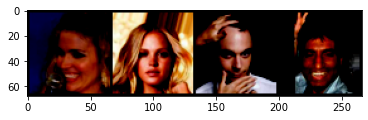

In [35]:
trial = next(iter(trainloader.__iter__()))

images, labels = trial['input'],1
print(labels)
show_images(images)

In [33]:
trial.keys()

dict_keys(['input'])

## 4. Define the Model Architecture
The VAE consists of an encoder that takes the images outputs 2 vectors of length `latent_size`. 

Traditionally, one is the vector of `means`, μ, and another is the vector of `standard deviations`, σ.

In this case however, to prevent the model from learning negative values of variance, we instead create a vector containing the `log(variance)`.

This gives us a collection of random variables ***X***, from which we sample to provide inputs to the Fully Connected layer using the `sample` function. 

The next part is the decoder which tries to reconstruct the image from the vector. 

The Adam optimiser is used here.

In [36]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encodinglayer1 = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU()
        )
        self.encodinglayer2_mean = nn.Sequential(nn.Linear(hidden_size, latent_size))
        self.encodinglayer2_logvar = nn.Sequential(nn.Linear(hidden_size, latent_size))
        self.decodinglayer = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid(),
        )

    def sample(self, log_var, mean):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.encodinglayer1(x)
        log_var = self.encodinglayer2_logvar(x)
        mean = self.encodinglayer2_mean(x)

        z = self.sample(log_var, mean)
        x = self.decodinglayer(z)

        return x, mean, log_var

In [37]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), 1024, 1, 1)

In [38]:
class DCVAE(nn.Module):
  def __init__(self, image_channels=3, image_dim=image_size, hidden_size=hidden_size, latent_size=latent_size):
    super(DCVAE, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(image_channels, 32, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 64, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, 4, 2),
        nn.LeakyReLU(0.2),
        Flatten(),
    )
    self.encoder_mean = nn.Linear(hidden_size, latent_size)
    self.encoder_logvar = nn.Linear(hidden_size, latent_size)
    self.fc = nn.Linear(latent_size, hidden_size)
    self.decoder = nn.Sequential(
                                UnFlatten(),
                                nn.ConvTranspose2d(hidden_size, 128, 5, 2),
                                nn.ReLU(),
                                nn.ConvTranspose2d(128, 64, 5, 2),
                                nn.ReLU(),
                                nn.ConvTranspose2d(64, 32, 6, 2),
                                nn.ReLU(),
                                nn.ConvTranspose2d(32, image_channels, 6, 2),
                                nn.Sigmoid()   
                              )
  
  def sample(self, log_var, mean):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mean)
  
  def forward(self, x):
    x = self.encoder(x)
    log_var = self.encoder_logvar(x)
    mean = self.encoder_mean(x)
    z = self.sample(log_var, mean)
    x = self.fc(z)
    x = self.decoder(x)

    return x, mean, log_var

In [39]:
vae = DCVAE().to('cuda')
# vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

### Load pretrained weights
Comment this out if you want to train from scratch.

In [40]:
vae.load_state_dict(torch.load(model_dir+"DCVAE.pt"))
# vae.load_state_dict(torch.load(model_dir+"VAE.pt"))

FileNotFoundError: [Errno 2] No such file or directory: 'results/model/DCVAE.pt'

## 5. Training the model
Set the model to the training mode first. 

Things to note, two types of loss are used here. The first one is just the reconstruction loss that compares the recontructed images to the original one using Binary Cross Entropy. 

The second one is called the [Kullback–Leibler divergence](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained) which gives a measure of how much a distibution diverges from another. We use this to force the encodings to distribute themselves around the centre of the latent space.

In [45]:
vae.train()

for epoch in range(100):
  for i, (images) in enumerate(trainloader):
    images = images['input'].to(device)
    optimizer.zero_grad()
    reconstructed_image, mean, log_var = vae(images)
    CE = F.binary_cross_entropy(reconstructed_image, images, reduction='sum')
    # for VAE
    # CE = F.binary_cross_entropy(
    #             reconstructed_image, images.view(-1, input_size), reduction="sum"
    #         )
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    loss = CE + KLD
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()

    if(i % 100 == 0):
      print("Loss:")
      print(loss.item() / len(images))

Loss:
-248942.421875
Loss:
-251913.265625
Loss:
-263036.0
Loss:
-264944.8125
Loss:
-263496.46875
Loss:
-266135.96875
Loss:
-261902.40625
Loss:
-268601.625
Loss:
-272506.28125
Loss:
-277022.78125
Loss:
-261012.59375
Loss:
-271453.125
Loss:
-266833.1875
Loss:
-270983.15625
Loss:
-281535.5
Loss:
-285114.125
Loss:
-291337.34375
Loss:
-281887.875
Loss:
-294548.21875
Loss:
-300520.1875
Loss:
-292638.28125
Loss:
-304273.09375
Loss:
-308249.6875
Loss:
-303627.03125
Loss:
-312139.46875
Loss:
-295744.4375
Loss:
-310177.65625
Loss:
-304294.875
Loss:
-314266.65625
Loss:
-298826.03125
Loss:
-312282.8125
Loss:
-320069.40625
Loss:
-307786.15625
Loss:
-315611.0625
Loss:
-299752.34375
Loss:
-312525.28125
Loss:
-317973.1875
Loss:
-319353.0625
Loss:
-319320.65625
Loss:
-324340.21875
Loss:
-317375.3125
Loss:
-321757.9375
Loss:
-323683.59375
Loss:
-323201.0625
Loss:
-324008.6875
Loss:
-325398.09375
Loss:
-326756.3125
Loss:
-327218.875
Loss:
-329273.15625
Loss:
-329555.46875
Loss:
-325621.875
Loss:
-329804.

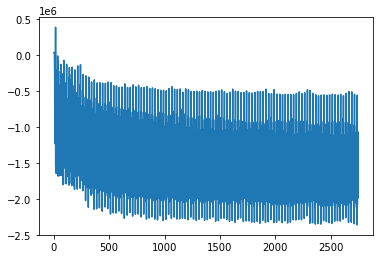

In [46]:
plt.plot(train_loss)
plt.show()

## 6. Evaluate performance on the test set
Set the model to the evaluation mode. This is important otherwise you will get inconsistent results.

We save the mean vectors and the labels in a separate list to visualise them later.

As we can see, the model has learnt to reconstruct the images pretty well. We can improve performance by training for longer or by increasing the latent vector size to encode more information.

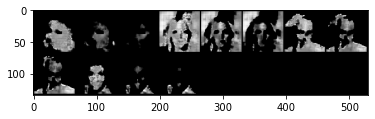

In [53]:
vae.eval()
vectors = []
with torch.no_grad():
  for i, (images) in enumerate(testloader):
    images = images['input'].to(device)
    reconstructed_image, mean, log_var = vae(images)
    reconstructed_image = reconstructed_image.view(-1, 1, image_size, image_size)
    labels=[1,1,1,1]
    temp = list(zip(labels, mean.tolist()))
    
    for x in temp:
      vectors.append(x)
    if(i%100 == 0):
      show_images(reconstructed_image.cpu())
      img_name = images_dir + "evaluation/DCVAE/" + str(i).zfill(3)
      # img_name = images_dir + "evaluation/VAE/" + str(i).zfill(3)
      #plt.savefig(img_name)
      plt.show()

## 7. Generate images from latent vectors
Here I have taken three vectors and I'll interpolate between them to show how the continuos latent space in a VAE allows you to smoothly tranistion between different types of images.

This code is for the DCVAE.


In [0]:
vae.eval()
start = np.array([-1.8611,  0.3629, -0.1625,  0.6801,  1.2033,  1.0312,  0.5436,  1.3066,
         0.2905,  0.1377,  0.5122, -0.1663,  2.3431, -0.0896, -0.5873, -1.4804,
         0.8141, -1.2197,  0.0484,  0.6414, -0.8172, -0.9543, -0.8818, -1.1465,
         0.2720,  1.1792,  1.8410, -0.4715,  1.4380,  0.5139,  1.2099, -0.5012])
middle = np.array([-0.4763, -0.4644, -0.3850,  0.6598,  0.9110,  0.4451,  0.4617, -0.0526,
         0.2808,  0.6080,  0.5532, -1.5506, -0.5199,  0.1359,  0.0373,  0.4284,
        -0.4134, -1.7078, -0.0309, -1.0195, -0.3151, -0.5569,  0.2832, -0.9132,
        -1.1339, -1.3196,  2.1297,  0.8122,  0.6849, -0.6710, -0.3507, -0.9001])
end = np.array([-1.6239,  0.2496, -1.0690, -0.8745,  0.4133,  2.2452, -0.2385, -0.6532,
         0.3818, -0.9425,  0.9404,  1.3901, -0.3327, -0.3719, -0.0365,  0.3240,
         0.4928, -0.4988, -1.2228, -0.1638,  0.6093, -0.5264, -1.6963, -0.3718,
         2.1971,  0.2166, -0.0821, -0.1722, -0.1896, -1.6610, -0.1497,  1.0655])
points = 50
linfit = interpolate.interp1d([1, points/2, points], np.vstack([start, middle, end]), axis=0)
with torch.no_grad():
  for i in range(2, points-1):
    z = linfit(i)
    z = torch.FloatTensor(z)
    print(z.shape)
    z = z.reshape((-1, 32))
    z = z.to(device)
    z = vae.fc(z)
    generated_images = vae.decoder(z)
    generated_images = generated_images.view(-1, 64, 64)
    img = generated_images[0].cpu()
    plt.imshow(img)
    img_name = images_dir + 'interpolate/' + str(i).zfill(3)
    plt.savefig(img_name)
    plt.show()


## 8. Visualise the latent representations of the images
Using Singular Value Decomposition, we perform Principal Component Analysis to visualise the two largest eigenvalues. Then we add the labels for each element and create a dataframe.

In [18]:
labels, z_vectors = list(zip(*vectors))
z_vectors = torch.tensor(z_vectors)
U, S, V = torch.svd(torch.t(z_vectors))
C = torch.mm(z_vectors, U[:, :2]).tolist()
C = [x + [labels[i]] for i, x in enumerate(C)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
df = pd.DataFrame(C, columns=['x', 'y', 'label']) 
df.head()

,x,y,label
0,-2.153874,-2.298586,3
1,3.375610,-2.676195,1
2,-0.851677,0.685897,2
3,1.400374,1.521139,9
4,-2.679109,-1.818430,2


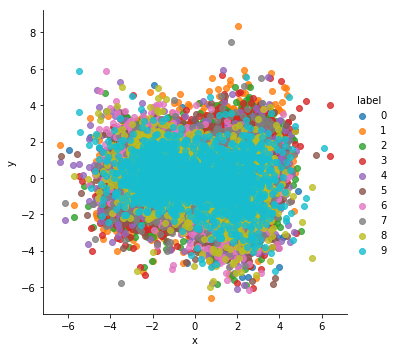

In [34]:
sns.lmplot( x="x", y="y", data=df, fit_reg=False, hue='label')

## 9. Saving the model
Save the model incase we need to load it again.

In [0]:
torch.save(vae.state_dict(), model_dir+"DCVAE.pt")
# Use this for saving the VAE model
# torch.save(vae.state_dict(), model_dir + "VAE.pt")